<a href="https://colab.research.google.com/github/pcashman21/feral-cat-census/blob/main/src/notebooks/pyimagesearch/mask_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

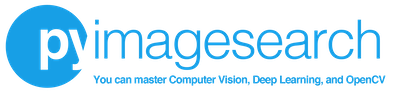

# Mask R-CNN with OpenCV
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch Plus](http://pyimg.co/plus)** Jupyter Notebooks!

This notebook is associated with the [Mask R-CNN with OpenCV](https://www.pyimagesearch.com/2018/11/19/mask-r-cnn-with-opencv/) blog post published on 2018-11-19.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch Plus Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook.

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2020 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch Plus at http://pyimg.co/plus/ today.*

### Download the code zip file

In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/mask-rcnn/mask-rcnn.zip
!unzip -qq mask-rcnn.zip
%cd mask-rcnn

--2023-10-26 14:48:28--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/mask-rcnn/mask-rcnn.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.92.177.130, 52.92.228.242, 52.92.180.98, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.92.177.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59494583 (57M) [binary/octet-stream]
Saving to: ‘mask-rcnn.zip’

mask-rcnn.zip       100%[===================>]  56.74M  17.0MB/s    in 3.3s    

2023-10-26 14:48:32 (17.0 MB/s) - ‘mask-rcnn.zip’ saved [59494583/59494583]

/content/mask-rcnn


## Blog Post Code

### Import Packages

In [2]:
# import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import random
import time
import cv2
import os

### Function to display images in Jupyter Notebooks and Google Colab

In [3]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### OpenCV and Mask R-CNN in images

In [4]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=True,
#	help="path to input image")
#ap.add_argument("-m", "--mask-rcnn", required=True,
#	help="base path to mask-rcnn directory")
#ap.add_argument("-v", "--visualize", type=int, default=0,
#	help="whether or not we are going to visualize each instance")
#ap.add_argument("-c", "--confidence", type=float, default=0.5,
#	help="minimum probability to filter weak detections")
#ap.add_argument("-t", "--threshold", type=float, default=0.3,
#	help="minimum threshold for pixel-wise mask segmentation")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "image": "images/example_01.jpg",
    "mask_rcnn": "mask-rcnn-coco",
    "visualize": 0,
    "confidence": 0.5,
    "threshold": 0.3
}

In [5]:
# load the COCO class labels our Mask R-CNN was trained on
labelsPath = os.path.sep.join([args["mask_rcnn"],
	"object_detection_classes_coco.txt"])
LABELS = open(labelsPath).read().strip().split("\n")

# load the set of colors that will be used when visualizing a given
# instance segmentation
colorsPath = os.path.sep.join([args["mask_rcnn"], "colors.txt"])
COLORS = open(colorsPath).read().strip().split("\n")
COLORS = [np.array(c.split(",")).astype("int") for c in COLORS]
COLORS = np.array(COLORS, dtype="uint8")

In [6]:
# derive the paths to the Mask R-CNN weights and model configuration
weightsPath = os.path.sep.join([args["mask_rcnn"],
	"frozen_inference_graph.pb"])
configPath = os.path.sep.join([args["mask_rcnn"],
	"mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"])

# load our Mask R-CNN trained on the COCO dataset (90 classes)
# from disk
print("[INFO] loading Mask R-CNN from disk...")
net = cv2.dnn.readNetFromTensorflow(weightsPath, configPath)

[INFO] loading Mask R-CNN from disk...


In [7]:
# load our input image and grab its spatial dimensions
image = cv2.imread(args["image"])
(H, W) = image.shape[:2]

# construct a blob from the input image and then perform a forward
# pass of the Mask R-CNN, giving us (1) the bounding box  coordinates
# of the objects in the image along with (2) the pixel-wise segmentation
# for each specific object
blob = cv2.dnn.blobFromImage(image, swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
(boxes, masks) = net.forward(["detection_out_final", "detection_masks"])
end = time.time()

# show timing information and volume information on Mask R-CNN
print("[INFO] Mask R-CNN took {:.6f} seconds".format(end - start))
print("[INFO] boxes shape: {}".format(boxes.shape))
print("[INFO] masks shape: {}".format(masks.shape))

[INFO] Mask R-CNN took 4.448613 seconds
[INFO] boxes shape: (1, 1, 100, 7)
[INFO] masks shape: (100, 90, 15, 15)


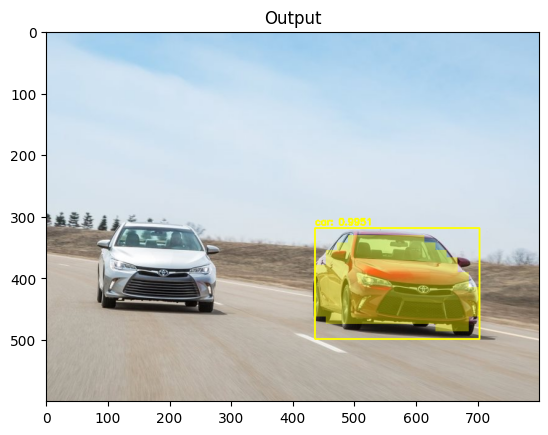

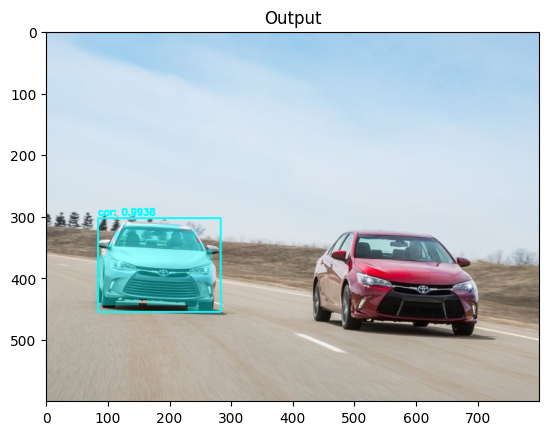

In [9]:
# loop over the number of detected objects
for i in range(0, boxes.shape[2]):
	# extract the class ID of the detection along with the confidence
	# (i.e., probability) associated with the prediction
	classID = int(boxes[0, 0, i, 1])
	confidence = boxes[0, 0, i, 2]

	# filter out weak predictions by ensuring the detected probability
	# is greater than the minimum probability
	if confidence > args["confidence"]:
		# clone our original image so we can draw on it
		clone = image.copy()

		# scale the bounding box coordinates back relative to the
		# size of the image and then compute the width and the height
		# of the bounding box
		box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H])
		(startX, startY, endX, endY) = box.astype("int")
		boxW = endX - startX
		boxH = endY - startY

        # extract the pixel-wise segmentation for the object, resize
		# the mask such that it's the same dimensions of the bounding
		# box, and then finally threshold to create a *binary* mask
		mask = masks[i, classID]
		mask = cv2.resize(mask, (boxW, boxH),
			interpolation=cv2.INTER_NEAREST)
		mask = (mask > args["threshold"])

		# extract the ROI of the image
		roi = clone[startY:endY, startX:endX]

        # check to see if are going to visualize how to extract the
		# masked region itself
		if args["visualize"] > 0:
			# convert the mask from a boolean to an integer mask with
			# to values: 0 or 255, then apply the mask
			visMask = (mask * 255).astype("uint8")
			instance = cv2.bitwise_and(roi, roi, mask=visMask)

			# show the extracted ROI, the mask, along with the
			# segmented instance
			plt_imshow("ROI", roi)
			plt_imshow("Mask", visMask)
			plt_imshow("Segmented", instance)

        # now, extract *only* the masked region of the ROI by passing
		# in the boolean mask array as our slice condition
		roi = roi[mask]

		# randomly select a color that will be used to visualize this
		# particular instance segmentation then create a transparent
		# overlay by blending the randomly selected color with the ROI
		color = random.choice(COLORS)
		blended = ((0.4 * color) + (0.6 * roi)).astype("uint8")

		# store the blended ROI in the original image
		clone[startY:endY, startX:endX][mask] = blended

        # draw the bounding box of the instance on the image
		color = [int(c) for c in color]
		cv2.rectangle(clone, (startX, startY), (endX, endY), color, 2)

		# draw the predicted label and associated probability of the
		# instance segmentation on the image
		text = "{}: {:.4f}".format(LABELS[classID], confidence)
		cv2.putText(clone, text, (startX, startY - 5),
			cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

		# show the output image
		plt_imshow("Output", clone)

### OpenCV and Mask R-CNN in video streams

In [ ]:
# first, let's get a video on which we can run our Mask R-CNN
!wget https://colab-notebook-videos.s3-us-west-2.amazonaws.com/guitar.mp4

In [ ]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--input", required=True,
#	help="path to input video file")
#ap.add_argument("-o", "--output", required=True,
#	help="path to output video file")
#ap.add_argument("-m", "--mask-rcnn", required=True,
#	help="base path to mask-rcnn directory")
#ap.add_argument("-c", "--confidence", type=float, default=0.5,
#	help="minimum probability to filter weak detections")
#ap.add_argument("-t", "--threshold", type=float, default=0.3,
#	help="minimum threshold for pixel-wise mask segmentation")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "input": "guitar.mp4",
    "output": "output.avi",
    "mask_rcnn": "mask-rcnn-coco",
    "visualize": 0,
    "confidence": 0.5,
    "threshold": 0.3
}

In [ ]:
# load the COCO class labels our Mask R-CNN was trained on
labelsPath = os.path.sep.join([args["mask_rcnn"],
	"object_detection_classes_coco.txt"])
LABELS = open(labelsPath).read().strip().split("\n")

# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

# derive the paths to the Mask R-CNN weights and model configuration
weightsPath = os.path.sep.join([args["mask_rcnn"],
	"frozen_inference_graph.pb"])
configPath = os.path.sep.join([args["mask_rcnn"],
	"mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"])

# load our Mask R-CNN trained on the COCO dataset (90 classes)
# from disk
print("[INFO] loading Mask R-CNN from disk...")
net = cv2.dnn.readNetFromTensorflow(weightsPath, configPath)

In [ ]:
# initialize the video stream and pointer to output video file
vs = cv2.VideoCapture(args["input"])
writer = None

# try to determine the total number of frames in the video file
try:
	prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
		else cv2.CAP_PROP_FRAME_COUNT
	total = int(vs.get(prop))
	print("[INFO] {} total frames in video".format(total))

# an error occurred while trying to determine the total
# number of frames in the video file
except:
	print("[INFO] could not determine # of frames in video")
	total = -1

In [ ]:
# loop over frames from the video file stream
while True:
	# read the next frame from the file
	(grabbed, frame) = vs.read()

	# if the frame was not grabbed, then we have reached the end
	# of the stream
	if not grabbed:
		break

	# resize the frame to have a maximum width of 400 pixels
	frame = imutils.resize(frame, width=400)

 	# construct a blob from the input frame and then perform a
	# forward pass of the Mask R-CNN, giving us (1) the bounding box
	# coordinates of the objects in the image along with (2) the
	# pixel-wise segmentation for each specific object
	blob = cv2.dnn.blobFromImage(frame, swapRB=True, crop=False)
	net.setInput(blob)
	start = time.time()
	(boxes, masks) = net.forward(["detection_out_final",
		"detection_masks"])
	end = time.time()

    # loop over the number of detected objects
	for i in range(0, boxes.shape[2]):
		# extract the class ID of the detection along with the
		# confidence (i.e., probability) associated with the
		# prediction
		classID = int(boxes[0, 0, i, 1])
		confidence = boxes[0, 0, i, 2]

		# filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		if confidence > args["confidence"]:
			# scale the bounding box coordinates back relative to the
			# size of the frame and then compute the width and the
			# height of the bounding box
			(H, W) = frame.shape[:2]
			box = boxes[0, 0, i, 3:7] * np.array([W, H, W, H])
			(startX, startY, endX, endY) = box.astype("int")
			boxW = endX - startX
			boxH = endY - startY

			# extract the pixel-wise segmentation for the object,
			# resize the mask such that it's the same dimensions of
			# the bounding box, and then finally threshold to create
			# a *binary* mask
			mask = masks[i, classID]
			mask = cv2.resize(mask, (boxW, boxH),
				interpolation=cv2.INTER_NEAREST)
			mask = (mask > args["threshold"])

			# extract the ROI of the image but *only* extracted the
			# masked region of the ROI
			roi = frame[startY:endY, startX:endX][mask]

            # grab the color used to visualize this particular class,
			# then create a transparent overlay by blending the color
			# with the ROI
			color = COLORS[classID]
			blended = ((0.4 * color) + (0.6 * roi)).astype("uint8")

			# store the blended ROI in the original frame
			frame[startY:endY, startX:endX][mask] = blended

			# draw the bounding box of the instance on the frame
			color = [int(c) for c in color]
			cv2.rectangle(frame, (startX, startY), (endX, endY),
				color, 2)

			# draw the predicted label and associated probability of
			# the instance segmentation on the frame
			text = "{}: {:.4f}".format(LABELS[classID], confidence)
			cv2.putText(frame, text, (startX, startY - 5),
				cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # check if the video writer is None
	if writer is None:
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 30,
			(frame.shape[1], frame.shape[0]), True)

		# some information on processing single frame
		if total > 0:
			elap = (end - start)
			print("[INFO] single frame took {:.4f} seconds".format(elap))
			print("[INFO] estimated total time to finish: {:.4f}".format(
				elap * total))

	# write the output frame to disk
	writer.write(frame)

# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()

Note that the above code block may take time to execute. If you are interested to view the video within Colab just execute the following code blocks. Note that it may be time-consuming.

Our output video is produced in `.avi` format. First, we need to convert it to `.mp4` format.

In [ ]:
!ffmpeg -i output.avi output.mp4

In [ ]:
#@title Display video inline
from IPython.display import HTML
from base64 import b64encode

mp4 = open("output.mp4", "rb").read()
dataURL = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % dataURL)

This code is referred from [this StackOverflow thread](https://stackoverflow.com/a/57378660/7636462).

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Mask R-CNN with OpenCV*](https://www.pyimagesearch.com/2018/11/19/mask-r-cnn-with-opencv/) blog post published on 2018-11-19.

# Code License Agreement
```
Copyright (c) 2020 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```